# Get sample weights

Use Census data about age and sex proportions in the US population to calculate weights for each survey response ID in the sample.

Output: age-sex-weights.csv

with columns for 
- Survey ResponseID
- Age
- Sex
- Age x Sex
- Age x Sex weight

Where:
- Sex is limited to the Male/Female binary and drops respondents with gender: 'Other' and 'Prefer not to say'.

Age is grouped to 3 groups from the 6 groups collected:
- 18 - 34 years
- 35 - 54 years
- 55 and older

In [26]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

RESPONSE_ID = 'Survey ResponseID'

census_data_age_sex_fpath = '../data/census/age-by-sex-2022-est.csv'
survey_data_fpath = '../data/survey-data/survey.pub.csv'
output_fpath = '../data/amazon-data/age-sex-weights.csv'

In [27]:
# Read in survey data and keep only the columns to be used below
# Want ResponseId, sex, age
sample_df = pd.read_csv(
    survey_data_fpath,  usecols=[RESPONSE_ID, 'Q-demos-gender', 'Q-demos-age']
).set_index(RESPONSE_ID)
print('%s respondents' % len(sample_df))
display(sample_df.head(3))

5027 respondents


,Q-demos-age,Q-demos-gender
Survey ResponseID,,
R_1ou69fj4DQGsVcp,35 - 44 years,Female
R_2UbJL30HRjK1sdD,45 - 54 years,Male
R_UPXamGKtmf4RVIZ,25 - 34 years,Male


In [28]:
# Add 'Age' column where Q-demos-age grouped to 3 groups
collapse_age_map = {
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 and older',
    '65 and older': '55 and older',
}
sample_df['Age'] = sample_df['Q-demos-age'].map(collapse_age_map)
sample_df.head(3)

,Q-demos-age,Q-demos-gender,Age
Survey ResponseID,,,
R_1ou69fj4DQGsVcp,35 - 44 years,Female,35 - 54 years
R_2UbJL30HRjK1sdD,45 - 54 years,Male,35 - 54 years
R_UPXamGKtmf4RVIZ,25 - 34 years,Male,18 - 34 years


We will drop participants outside the Male/Female binary

In [29]:
sample_df['Q-demos-gender'].value_counts()

Q-demos-gender
Female               2589
Male                 2311
Other                 116
Prefer not to say      11
Name: count, dtype: int64

In [31]:
sample_df['Sex'] = sample_df['Q-demos-gender'].map({'Female':'Female', 'Male':'Male'})
sample_df = sample_df.dropna()
print('%s participants after dropping those outside the Male/Female binary' % len(sample_df))
sample_df.head(3)

4900 participants after dropping those outside the Male/Female binary


,Q-demos-age,Q-demos-gender,Age,Sex
Survey ResponseID,,,,
R_1ou69fj4DQGsVcp,35 - 44 years,Female,35 - 54 years,Female
R_2UbJL30HRjK1sdD,45 - 54 years,Male,35 - 54 years,Male
R_UPXamGKtmf4RVIZ,25 - 34 years,Male,18 - 34 years,Male


In [32]:
# Create the Age x Sex column
sample_df['Age x Sex'] = sample_df.apply(lambda r: ('%s x %s') % (r['Age'], r['Sex']), axis=1)
sample_df.head(3)

,Q-demos-age,Q-demos-gender,Age,Sex,Age x Sex
Survey ResponseID,,,,,
R_1ou69fj4DQGsVcp,35 - 44 years,Female,35 - 54 years,Female,35 - 54 years x Female
R_2UbJL30HRjK1sdD,45 - 54 years,Male,35 - 54 years,Male,35 - 54 years x Male
R_UPXamGKtmf4RVIZ,25 - 34 years,Male,18 - 34 years,Male,18 - 34 years x Male


## Census data

Using Census data:

> Annual Estimates of the Resident Population by Single Year of Age and Sex for the United States: April 1, 2020 to July 1, 2022 (NC-EST2022-AGESEX-RES)

About the data: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-AGESEX-RES.pdf

The key for SEX is as follows:

- 0 = Total
- 1 = Male
- 2 = Female

AGE is single-year of age (0, 1, 2, . . ., 99, 100+ years) and 999 is used to indicate total population. (i.e. AGE=100 includes 100+)

We limit to 18+


In [33]:
census_age_sex_df = pd.read_csv(census_data_age_sex_fpath).rename(
    columns={'POPESTIMATE2022': 'N'}
)
census_age_sex_df.head(3)

,SEX,AGE,N
0,0,0,3683113
1,0,1,3588817
2,0,2,3693362


In [34]:
# drop total and anyone under 18 (recalculate totals with 18+)
print('census N=%s with age < 18; we drop them' % census_age_sex_df[(census_age_sex_df['SEX']==0) & (census_age_sex_df['AGE']<18)]['N'].sum())
census_age_sex_df = census_age_sex_df[
    (census_age_sex_df['AGE'] >= 18) & (census_age_sex_df['AGE'] <= 100)
]
# census_age_sex_df

census N=72450827 with age < 18; we drop them


## Set up weights

By comparing sample and census data

Set the weights as census proportion/sample proportion

In [35]:
def set_proportions_and_bias(df, roundto=3):
    """
    Adds columns for census proportion, survey proportion, bias
    Expects dataframe (df) with columns 'census N', 'survey N'
    Returns updated df
    """
    df['census proportion'] = round(df['census N']/df['census N'].sum(), roundto)
    df['survey proportion'] = round(df['survey N']/df['survey N'].sum(), roundto)
    df['census %'] = df['census proportion'].apply(lambda p: '%0.1f%%'%(100*p))
    df['survey %'] = df['survey proportion'].apply(lambda p: '%0.1f%%'%(100*p))
    df['bias'] = df['survey proportion'] - df['census proportion']
    return df

# Plots to compare survey vs census data

def plot_bias(df, ax=None):
    if ax is None: fig,ax = plt.subplots()
    df['bias'].plot(kind='barh')
    ax.set_xlabel('Bias')
    return ax

def plot_census_vs_survey_pops(df, ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    width = 0.4
    (df['census proportion']
     .plot(
        kind='barh', color='lightgray', edgecolor='black', #hatch='//',
        label='census',
        ax=ax, width=width, position=1
    ))
    (df['survey proportion']
     .plot(
        kind='barh', color='black',
        label='survey',
        ax=ax, width=width, position=0)
    )
    ax.legend()
    ax.set_xlabel('Proportion')
    return ax

Our sampling frame without stratification compared to census data:


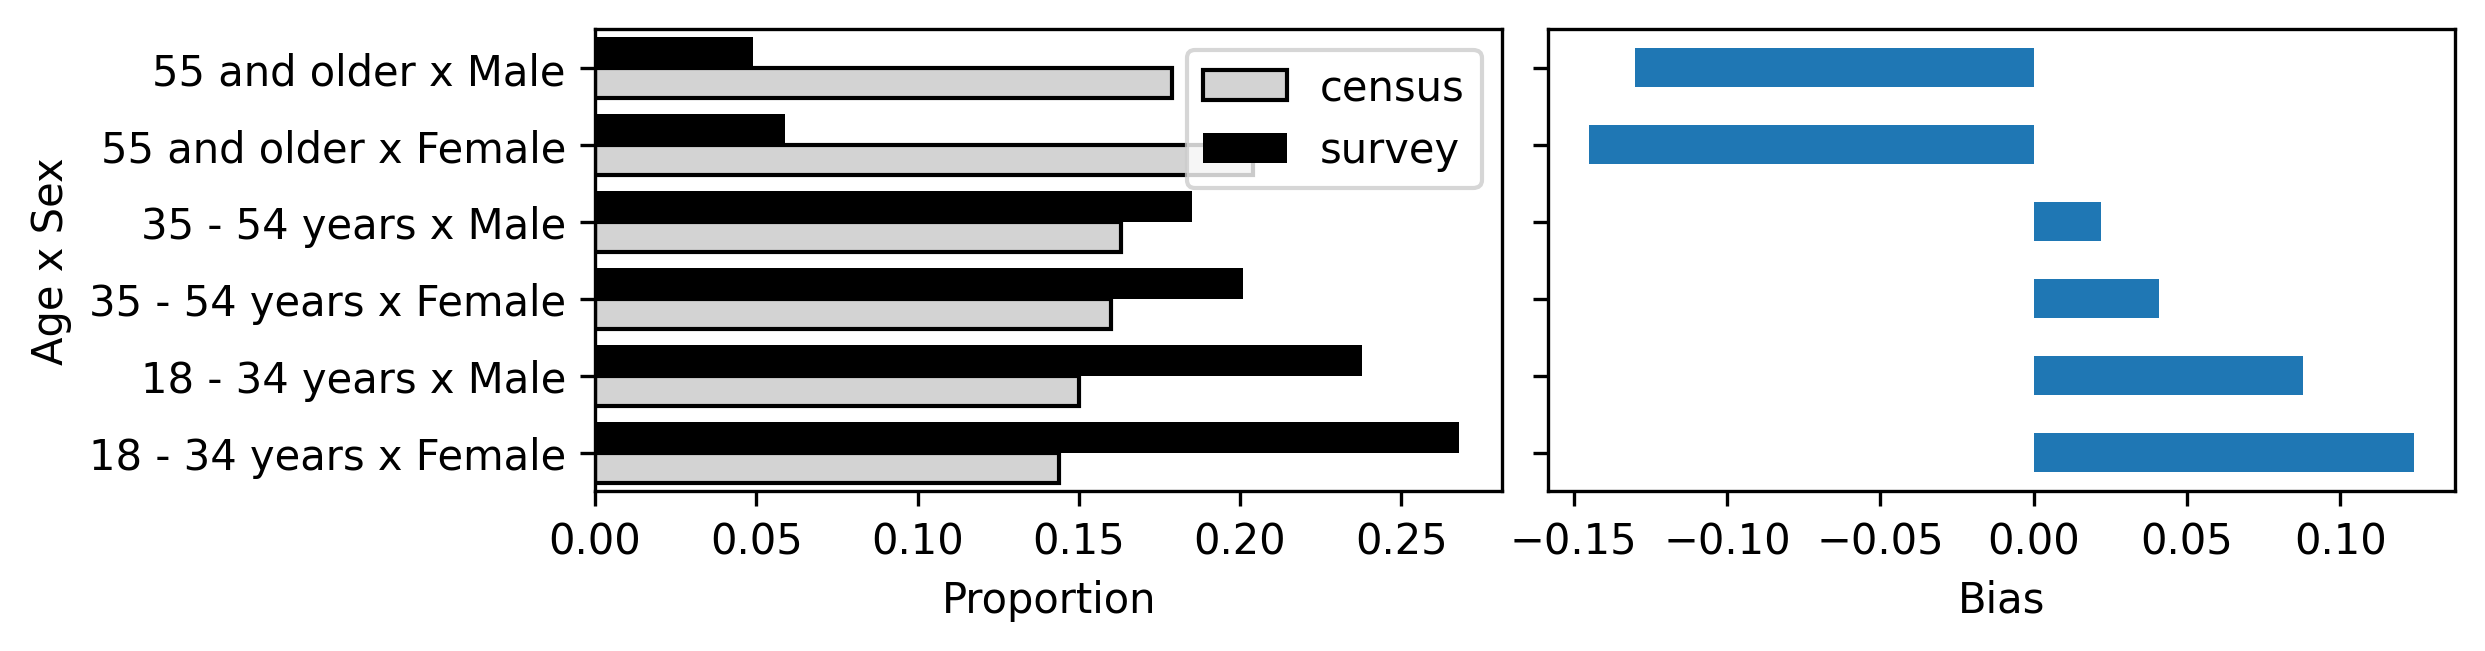

,survey N,census N,census proportion,survey proportion,census %,survey %,bias,Age x Sex weight
Age x Sex,,,,,,,,
18 - 34 years x Female,1312,37621213,0.144,0.268,14.4%,26.8%,0.124,0.537
18 - 34 years x Male,1166,39208218,0.150,0.238,15.0%,23.8%,0.088,0.630
35 - 54 years x Female,987,41727191,0.160,0.201,16.0%,20.1%,0.041,0.796
35 - 54 years x Male,906,42399819,0.163,0.185,16.3%,18.5%,0.022,0.881
55 and older x Female,290,53279042,0.204,0.059,20.4%,5.9%,-0.145,3.458
55 and older x Male,239,46601247,0.179,0.049,17.9%,4.9%,-0.130,3.653


In [46]:
print('Our sampling frame without stratification compared to census data:')
age_sex_df = sample_df['Age x Sex'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_sex_df['census N'] = [
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
]
age_sex_df = set_proportions_and_bias(age_sex_df)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.05)
plot_census_vs_survey_pops(age_sex_df, ax=ax1)
plot_bias(age_sex_df, ax=ax2)
plt.show()
age_sex_df['Age x Sex weight'] = age_sex_df['census proportion']/age_sex_df['survey proportion']
age_sex_df.round(3)

### Assign the weights to the sample and save for later use

In [39]:
sample_df['Age x Sex weight'] = sample_df['Age x Sex'].map(age_sex_df['Age x Sex weight'])
sample_df.head(3)

,Q-demos-age,Q-demos-gender,Age,Sex,Age x Sex,Age x Sex weight
Survey ResponseID,,,,,,
R_1ou69fj4DQGsVcp,35 - 44 years,Female,35 - 54 years,Female,35 - 54 years x Female,0.796020
R_2UbJL30HRjK1sdD,45 - 54 years,Male,35 - 54 years,Male,35 - 54 years x Male,0.881081
R_UPXamGKtmf4RVIZ,25 - 34 years,Male,18 - 34 years,Male,18 - 34 years x Male,0.630252
R_2dYk5auG9Fv5Qve,35 - 44 years,Male,35 - 54 years,Male,35 - 54 years x Male,0.881081
R_2aP0GyIR66gSTiR,25 - 34 years,Male,18 - 34 years,Male,18 - 34 years x Male,0.630252


In [44]:
# save the data
print('Saving %s survey responseId weights to %s' % (len(sample_df), output_fpath))
sample_df[['Age','Sex','Age x Sex','Age x Sex weight']].to_csv(output_fpath)

Saving 4900 survey responseId weights to ../data/amazon-data/age-sex-weights.csv


In [45]:
# Test can read from csv
pd.read_csv(output_fpath).head(3)

,Survey ResponseID,Age,Sex,Age x Sex,Age x Sex weight
0,R_1ou69fj4DQGsVcp,35 - 54 years,Female,35 - 54 years x Female,0.796020
1,R_2UbJL30HRjK1sdD,35 - 54 years,Male,35 - 54 years x Male,0.881081
2,R_UPXamGKtmf4RVIZ,18 - 34 years,Male,18 - 34 years x Male,0.630252
